In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, EllipticEnvelope, GraphicalLassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

plt.style.use("seaborn-v0_8")

In [9]:
random_state = 42

df = pd.read_csv("train.csv")

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

# "stratify" is set because the target is very imbalanced
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.99, stratify=df_y, random_state=random_state
)
print("Train: {}\nTest: {}".format(X_train.shape, X_test.shape))

Train: (2521, 90)
Test: (249654, 90)


---
# Preprocessing

- [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) is tested
- [Shrinkage, Oracle Approximating Shrinkage (OAS)](https://en.wikipedia.org/wiki/Shrinkage_(statistics)#:~:text=In%20statistics%2C%20shrinkage%20is%20the,coefficient%20of%20determination%20'shrinks') is tested because requires normal distributed data
- [Empirical covariance](https://scikit-learn.org/stable/modules/covariance.html#empirical-covariance) is tested because requires normal distributed data
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) is tested because it's robust to anomalies, requires normal and unimodal distributed data
- LDA with eigenvalues solver for dimensionality reduction

In [10]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),
    ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    (
        "min-max + pca 0.95",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("pca", PCA(random_state=random_state)),
        ],
        {
            "pca__svd_solver": ["full"],
            "pca__n_components": [0.95],
            "pca__whiten": [True, False],
        },
    ),
    (
        "min-max + lda2",
        [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [
                # EllipticEnvelope(random_state=random_state),
                # EmpiricalCovariance(),
                # GraphicalLassoCV(cv=3), # too much computational expensive
                OAS(),
                # None,
            ],
        },
    ),
]

---
---
# Modeling
- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters
- Then it's chosen the best model with the best preprocess method looking at the R^2 score
- "StratifiedKFold" is chosen to keep the proportion of imbalanced target lables

In [11]:
def gridSearch(name_estimator, estimator, param_estimator, cv):
    searches = {}
    predictions = {}
    for name_step, transformers, param_grid in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe, param_grid={**param_estimator, **param_grid}, n_jobs=-1, cv=cv, verbose=3, pre_dispatch=8
        )

        gs.fit(X_train.values, y_train)

        y_pred = gs.best_estimator_.predict(X_test.values)

        searches[name_step] = gs
        predictions[name_step] = y_pred

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
            )
        )
    return searches, predictions

In [88]:
def print_store_results(searches: dict, predictions: dict, name_est):
    best_r2_score = -100
    best_preprocessor = []
    best_estimator = None
    best_search_name = None

    for name_step, gs in searches.items():
        r2 = r2_score(y_test, predictions[name_step])

        if r2 > best_r2_score:
            best_r2_score = r2
            best_search_name = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but estimator
            best_estimator = gs.best_estimator_[-1]

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2, mean_squared_error(y_test, predictions[name_step])
            )
        )

        if name_step in [
            "min-max + pca",
            "min-max + pca 0.95",
            "min-max + std-scaler + pca 0.95",
            "min-max + lda1",
            "min-max + lda2",
            "min-max + lda3",
            "std-scaler + lda2",
        ]:
            ratio = gs.best_estimator_[1].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["lda1", "lda2", "lda3"]:
            ratio = gs.best_estimator_[0].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["min-max + ica"]:
            print("\t\t{}: number of components={}".format(name_step, len(gs.best_estimator_[1].components_)))

    file = open(name_est + "_preproc_" + ".save", "wb")
    pickle.dump(best_preprocessor, file)
    file = open(name_est + "_model_" + ".save", "wb")
    pickle.dump(best_estimator, file)
    file.close()

    print("\nSAVED: ----> {} data. R^2: {}".format(best_search_name, best_r2_score))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.grid(None)
    fig.tight_layout()
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        np.round(predictions[best_search_name]).astype(int),
        ax=ax,
        xticks_rotation=80,
        include_values=False,
        cmap="icefire"
    )

---
## Linear Regression
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA is a bit better than PCA but with fewer components (53)
- The best result is R^2=0.237, MSE=83.99, with all the following:
    - Raw data
    - Standard-scaled data
    - Min-max + LDA with EmpiricalCovariance as covariance estimators and "eigen" solver
    - Min-max + LDA with "svd" solver and store_covariance=True

In [ ]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {}

searches, predictions = gridSearch("lr", LinearRegression(), param_estimator, cv)

----> raw data. Params: {}. R^2: 0.19019775099934288. MSE: 89.24294712787399
----> std-scaled data. Params: {}. R^2: 0.19019775099934288. MSE: 89.24294712787399
----> min-maxed data. Params: {}. R^2: 0.19019775099934288. MSE: 89.24294712787399
----> min-max + pca 0.95 data. Params: {'pca__n_components': 0.95, 'pca__svd_solver': 'full', 'pca__whiten': True}. R^2: 0.19812439318819475. MSE: 88.36940434550426
		min-max + pca 0.95: number of components=60, total variance=0.9523106256246334
----> min-max + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.1991584155599826. MSE: 88.25545158238417
		min-max + lda2: number of components=53, total variance=1.1749134329928883

SAVED: ----> min-max + lda2 data. R^2: 0.1991584155599826


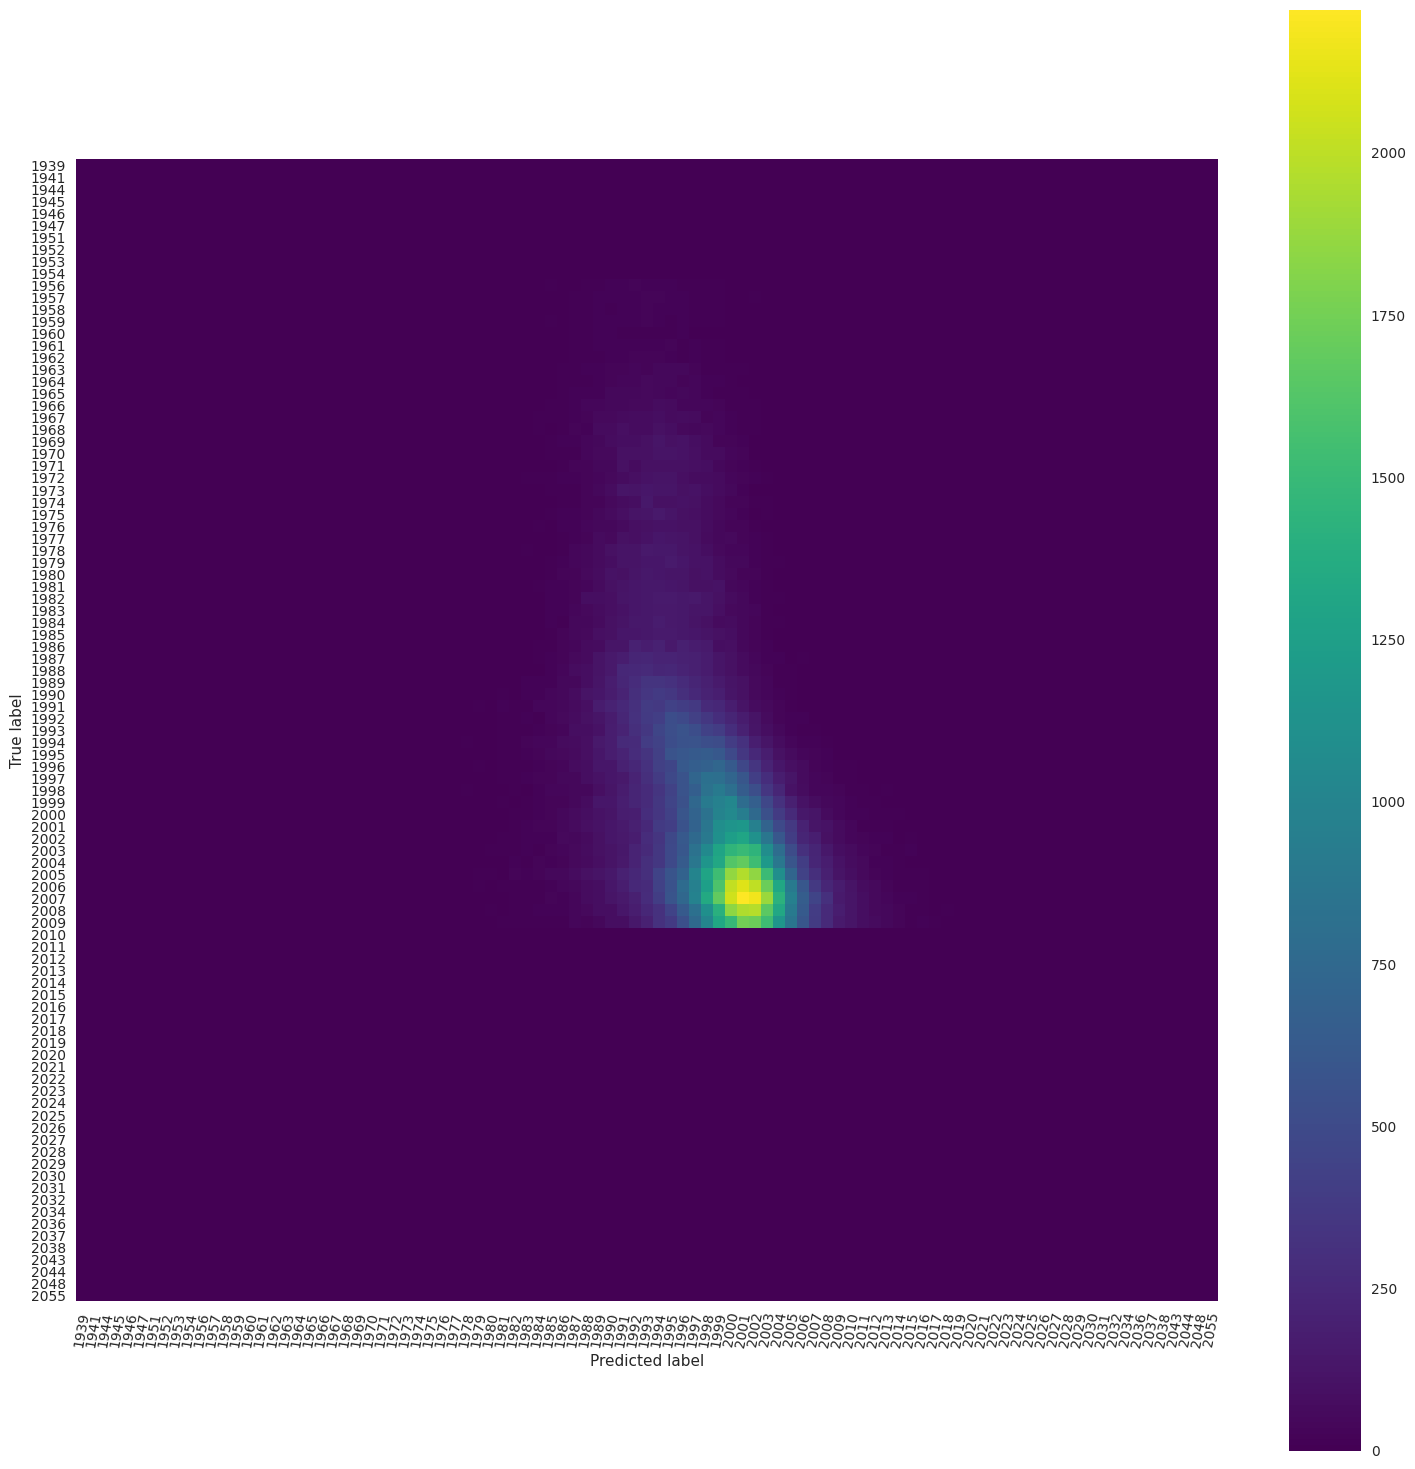

In [89]:
print_store_results(searches, predictions, "lr")

---
## RandomForestRegressor
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA gives better results than PCA with even less components (53). 
- LDA gives better results with MinMax preprocessing instead of StandardScaling and MinMax+StandardScaling.
- The following results are with a preprocess of MinMax + LDA:
    - Keeping the number of trees to 200 with samples percentage per tree of 10% (for computational reasons):
        - The best covariance estimator is EllipticEnvelope (MinCovDet), over EmpiricalCovariance, OAS and no-shrinkage: R^2: 0.30, MSE: 76
    - Incrementing the number of trees (500) and reducing the percentage of samples per tree (2.5%) (for computational reasons), the results were a bit worse but very similar
    - Decrementing the number of trees (5) with samples percentage per tree of 100%, the results were far worse (R^2=0.16, MSE=92)
- Therefore the best combination is:
    - MinMax preprocess + LDA preprocess with EllipticEnvelope covariance estimator and "eigen" as solver
    - RandomForest with 200 estimators and 100% of sample per estimator: R^2=0.3158, MSE=75.389
    - Therei s a very big downside with this configuration: it is more than 2GB of model size, in comparison with the 328MB of the same model but with 0.1% of samples per tree (the results are the one above).

In [ ]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "rf__max_samples": [0.1],
    "rf__criterion": ["squared_error"],
    "rf__n_estimators": [200],
}

searches, predictions = gridSearch("rf", RandomForestRegressor(n_jobs=-1), param_estimator, cv)

In [ ]:
print_store_results(searches, predictions, "rf")

----> min-max + lda2 data. Params: {'lda__covariance_estimator': EllipticEnvelope(random_state=42), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.025, 'rf__n_estimators': 500}. R^2: 0.29396840748747954. MSE: 77.80217040450476
		min-max + lda2: number of components=53, total variance=1.1984870090370168

SAVED: ----> min-max + lda2 data. R^2: 0.29396840748747954


---
## KNN
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- The following search was not exaustive: we not tryed all the possible combinations, but we followed the more promising paths
    - The best result: R^2=? , MSE=?
    - MinMax + LDA performed better than PCA (and its combinations with preprocessing tecniques)
    - Best metric is *cosine*, over cityblock, euclidean, nan_euclidean, with "weights"="distance" over "uniform"
    - Best covariance estimator is *OAS*, over EllipticEnvelope, EmpiricalCovariance and no-shrinkage
    - Best number of neighbors is 20 (tryed in this order 5,30,25,20,15,17,18,19)

In [10]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "knr__n_neighbors": [20],
    "knr__weights": ["distance"],  # "uniform"
    "knr__metric": [
        # "cityblock",
        "cosine",
        # "euclidean",
        # "nan_euclidean",
    ],
}

searches, predictions = gridSearch("knr", KNeighborsRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
----> min-max + lda2 data. Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 19, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.32153305640465957. MSE: 74.76464413098074


----> min-max + lda2 data. Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 19, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.32153305640465957. MSE: 74.76464413098074
		min-max + lda2: number of components=53, total variance=1.4918447986354724

SAVED: ----> min-max + lda2 data. R^2: 0.32153305640465957


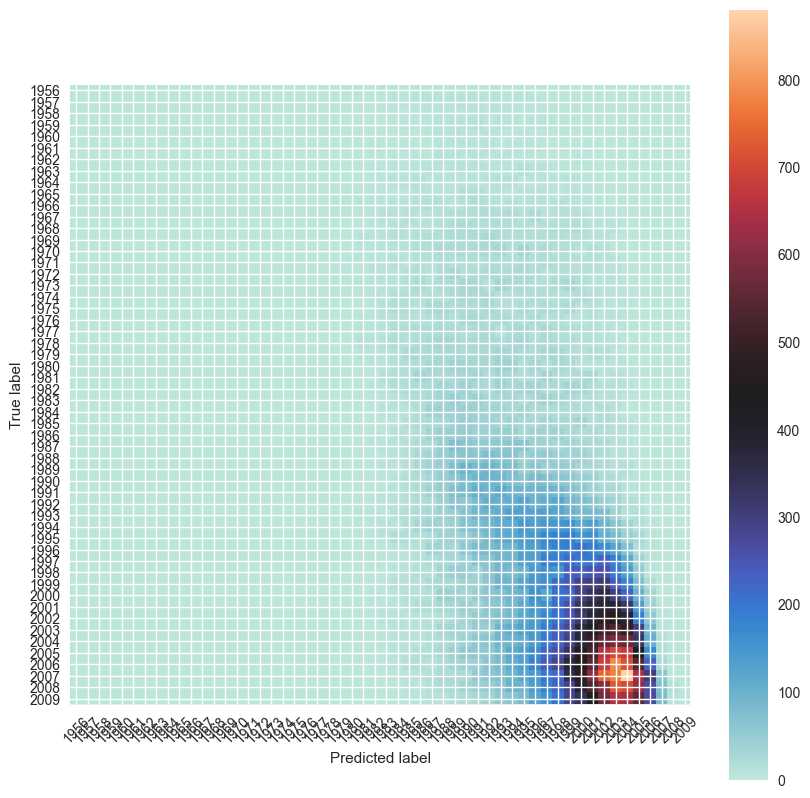

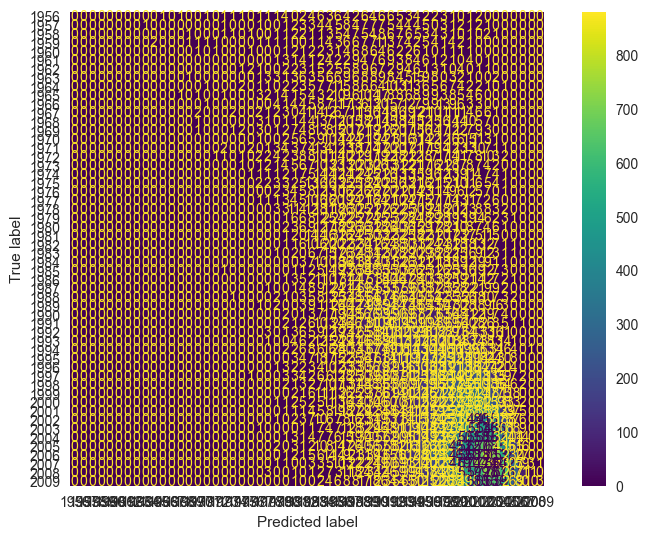

In [11]:
print_store_results(searches, predictions, "knr")

---
## SVM

In [ ]:
cv = StratifiedKFold(n_splits=5)

param_estimator = {
    "svr__C": [
        *range(1, 10, 1),
        *range(10, 100, 10),
        *range(100, 1000, 100),
    ],
    "svr__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svr__gamma": ["scale", "auto"],
}

searches, predictions = gridSearch("svr", SVR(), param_estimator, cv)

In [ ]:
print_store_results(searches, predictions, "svr")